# Python Stacked Ensemble Benchmarks

The aim of this notebook is to identify some different python stacking packages, compare their performances to mlens and take note of their differing functionality. There are many more ensembling packages available but these were picked as they were well maintained and had an SKLearn style APIs.

In [20]:
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pylab as plt

from sklearn import datasets
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score as cvs

from mlxtend.regressor import StackingRegressor as mlx_StackingRegressor

from mlens.metrics import make_scorer
from mlens.ensemble import SuperLearner
from mlens.model_selection import Evaluator

from mlbox import StackingRegressor as mlb_StackingRegressor

warnings.filterwarnings('ignore')

In [2]:
data = datasets.california_housing.fetch_california_housing()

X, y = data['data'], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    train_size=0.8, random_state=321)

### Establish some Individual Model Benchmarks

Try Linear Regression, XGBoost and LightGBM as they are well known machine learning models.

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mse(y_test, lr.predict(X_test))

0.58740384298451276

In [22]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)
mse(y_test, xgbr.predict(X_test))

0.30695328973624081

In [23]:
lgbr = lgb.LGBMRegressor(n_estimators=30)
lgbr.fit(X_train, y_train)
mse(y_test, lgbr.predict(X_test))

0.3001026140472941

### Test some Python packages with Ensembling functionality.

Here we start with the simple but very useful [Mlxtend](https://github.com/rasbt/mlxtend). Despite its name it is not stacking in the truest sense (or at least a [Super Learner](http://mlens.readthedocs.io/en/0.1.x/ensembles.html#id4)) as the meta-models are not fitted on the holdout predictions from k-fold cv in the previous layers.

In [14]:
def print_scores(scores_df, name):
    print("Train Mean Squared Error: %.4f"
          % scores_df.loc['train', name])

    print("Train CV mean: %.4f"
          % scores_df.loc['mean_cv', name])

    print("Train CV std: %.4f"
          % scores_df.loc['std_cv', name])

    print("Test Mean Squared Error: %.4f"
          % scores_df.loc['test', name])

In [15]:
stregr = mlx_StackingRegressor(regressors=[lgbr, xgbr],
                               meta_regressor=lr)
scores = cvs(stregr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
stregr.fit(X_train, y_train)

scores_df = pd.DataFrame(index=['train', 'mean_cv', 'std_cv', 'test'])
scores_df['mlxtend'] = [mse(y_train, stregr.predict(X_train)), -scores.mean(),
                        scores.std(), mse(y_test, stregr.predict(X_test))]

print_scores(scores_df, 'mlxtend')

Train Mean Squared Error: 0.2316
Train CV mean: 0.2622
Train CV std: 0.0097
Test Mean Squared Error: 0.2924


Let's compare these results to an mlens SuperLearner. In order to calculate cv-scores for the SuperLearner we use the `Evaluate` function.

In [16]:
ensemble = SuperLearner(folds=5, scorer=mse)
ensemble.add([xgb.XGBRegressor(), lgb.LGBMRegressor(n_estimators=30)])
ensemble.add_meta([LinearRegression()])

evl = Evaluator(make_scorer(mse), cv=5, shuffle=False)
evl.fit(X_train, y_train, ensemble, {}, n_iter=1)

ensemble.fit(X_train, y_train)

scores_df['mlens'] = [mse(y_train, ensemble.predict(X_train)),
                      evl.summary['test_score_mean']['superlearner'],
                      evl.summary['test_score_std']['superlearner'],
                      mse(y_test, ensemble.predict(X_test))]

print_scores(scores_df, 'mlens')

/usr/local/lib/python3.5/dist-packages/mlens/model_selection/model_selection.py:486: UserWarning: No valid parameters found for superlearner. Will fit and score once with given parameter settings.
  "settings.".format(key))


Train Mean Squared Error: 0.2321
Train CV mean: 0.2612
Train CV std: 0.0094
Test Mean Squared Error: 0.2916


Now we can try a similar approach with [MLBox](https://github.com/AxeldeRomblay/MLBox). This package is powerful but is aimed more at parameter searches over the whole pipeline rather than ensembling. As a result it does not have a method for outputting the fold scores so that we can get `mean` and `std` cv-scores.

In [17]:
mlbs = mlb_StackingRegressor(base_estimators=[xgb.XGBRegressor(), lgb.LGBMRegressor(n_estimators=30)],
                             level_estimator=LinearRegression())
mlbs.fit(pd.DataFrame(X_train), pd.Series(y_train))

scores_df['mlbox'] = [mse(pd.Series(y_train), mlbs.predict(pd.DataFrame(X_train))),
                      np.nan, np.nan,
                      mse(pd.Series(y_test), mlbs.predict(pd.DataFrame(X_test)))]

print_scores(scores_df, 'mlbox')


[=============================================================================] LAYER [===================================================================================]

> fitting estimator n°1 : {'subsample': 1, 'silent': True, 'min_child_weight': 1, 'reg_alpha': 0, 'max_delta_step': 0, 'reg_lambda': 1, 'nthread': -1, 'seed': 0, 'base_score': 0.5, 'colsample_bytree': 1, 'max_depth': 3, 'colsample_bylevel': 1, 'objective': 'reg:linear', 'missing': None, 'gamma': 0, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'n_estimators': 100} ...

> fitting estimator n°2 : {'seed': 0, 'subsample': 1, 'boosting_type': 'gbdt', 'subsample_freq': 1, 'reg_alpha': 0, 'max_bin': 255, 'reg_lambda': 0, 'nthread': -1, 'objective': 'regression', 'min_split_gain': 0, 'num_leaves': 31, 'n_estimators': 30, 'min_child_samples': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'silent': True, 'max_depth': -1, 'subsample_for_bin': 50000, 'colsample_bytree': 1} ...


[============================================

Lastly we run the [vecstack](https://github.com/vecxoz/vecstack) ensemble. This package does not run as the previous three packages do, with an estimator object. This package creates the training and hold out test sets of each estimator. This shifts complexity to the user but would allow some added flexibility.

In [18]:
from vecstack import stacking

S_train, S_test = stacking([xgb.XGBRegressor(), lgb.LGBMRegressor(n_estimators=30)],
                            X_train, y_train, X_test, n_folds=5, metric=mse)

_, X_train_test = stacking([xgb.XGBRegressor(), lgb.LGBMRegressor(n_estimators=30)],
                            X_train, y_train, X_train, n_folds=5, metric=mse)

lr = LinearRegression()
lr = lr.fit(S_train, y_train)

re_split = [mse(y_i_train, lr.predict(X_i_train))
            for y_i_train, X_i_train in zip(np.array_split(y_train, 5, axis=0),
                                            np.array_split(S_train, 5, axis=0))]

scores_df['vecstack'] = [mse(y_train, lr.predict(X_train_test)),
                      np.mean(re_split), np.std(re_split),
                      mse(pd.Series(y_test), lr.predict((S_test)))]

print_scores(scores_df, 'vecstack')

Train Mean Squared Error: 0.2317
Train CV mean: 0.2612
Train CV std: 0.0094
Test Mean Squared Error: 0.2919


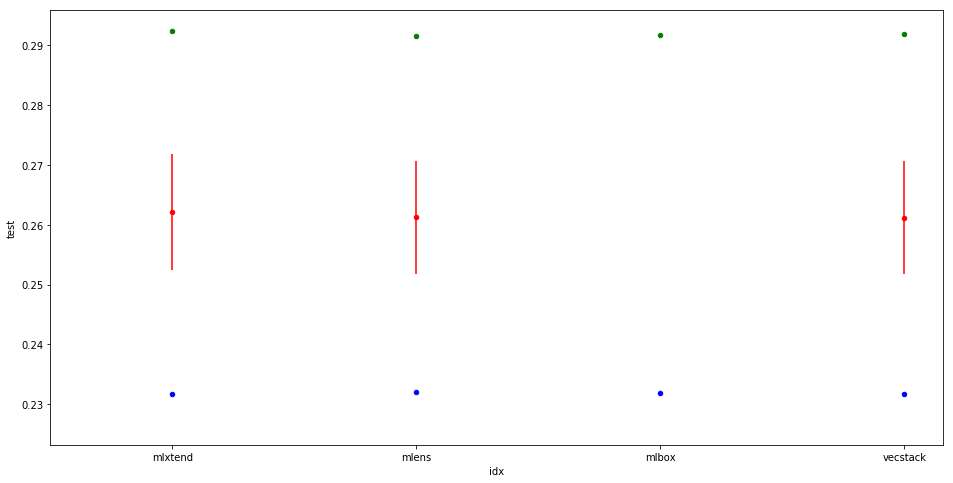

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 8

fig, ax = plt.subplots()

scores_df.loc['idx', :] = range(4)
scores_df.T.plot.scatter('idx', 'train', c='b', ax=ax)
scores_df.T.plot.scatter('idx', 'mean_cv', c='r', ax=ax, yerr='std_cv')
scores_df.T.plot.scatter('idx', 'test', c='g', ax=ax)

plt.xlim(-0.5, None)
plt.xticks(range(4), scores_df.columns)
plt.show()

# Conclusion
From this comparison, we can see that each stacking packages gave very similar results. Mlxtend did behave slightly differently as it is not a Super Learner ensemble, but even this is barely noticeable in the above scatter plot. The main differences in the packages are how you can go about building upon these models to create a more accurate model. This will be analysed in the following notebook.